# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
from matplotlib import pyplot as plt, pylab
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [3]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.8.9
IPython version      : 8.3.0

numpy      : 1.22.4
scipy      : 1.8.1
pandas     : 1.4.1
matplotlib : 3.5.2
statsmodels: 0.13.2
sklearn    : 0.0

Compiler    : Clang 13.1.6 (clang-1316.0.21.2.5)
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 6b9dde1ab59833412f5f60a03c91794cb9e1b2ce



In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [8]:
# def plot_validation_curves(param_values, grid_cv_results_):
#     train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
#     valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
#     train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
#     valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
#     plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
#                      facecolor=train_line[0].get_color(), alpha=0.2)
#     plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
#                      facecolor=valid_line[0].get_color(), alpha=0.2)
#     plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)

In [10]:
knn_score = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1)

In [11]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
print(np.mean(knn_score))
print(accuracy_score(y_valid, knn.predict(X_valid)))

0.5541549584575395
0.580943351505096


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
forest = RandomForestClassifier(random_state=17, oob_score=True)

In [15]:
forest.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=17)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [16]:
print(forest.oob_score_)
print(accuracy_score(y_valid, forest.predict(X_valid)))

0.7268847795163584
0.7169945484712017


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [17]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [18]:
logit = LogisticRegression(random_state=17)

In [19]:
logit_score = cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1)

In [20]:
logit.fit(X_train, y_train)

LogisticRegression(random_state=17)

In [21]:
print(np.mean(logit_score))
print(accuracy_score(y_valid, logit.predict(X_valid)))

0.7569601896110397
0.77790945721735


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [22]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 989 ms, sys: 1.34 s, total: 2.33 s
Wall time: 5.01 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

In [23]:
logit_grid_searcher1.Cs_

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [24]:
logit_grid_searcher1.scores_[1].mean(axis=1)

array([0.65799898, 0.66968004, 0.65406504, 0.65691057, 0.6671748 ])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [25]:
def plot_logit_validation_curves(reg_par_val):
    dict = {}
    for i in tqdm(reg_par_val):
        logit = LogisticRegression(C=i, random_state=17)
        logit.fit(X_train, y_train)
        dict[i] = np.mean(cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1))
    #last value and key are the best       
    print({k: v for k, v in sorted(dict.items(), key=lambda item: item[1])})
    logit_c_values, logit_mean_cv_scores = zip(*dict.items())
    plt.plot(logit_c_values, logit_mean_cv_scores)
    plt.grid(True)
    plt.xlabel('logit c values')
    plt.ylabel('logit mean cv scores')
    plt.show()
        
    plt.savefig('test.png', bbox_inches='tight')

In [26]:
plot_logit_validation_curves(logit_grid_searcher1.Cs_)

  0%|          | 0/10 [00:00<?, ?it/s]

{0.0001: 0.32127725410902386, 0.00046415888336127773: 0.46768837827055504, 0.002154434690031882: 0.5504962670016825, 0.01: 0.6535247594551533, 0.046415888336127774: 0.7142849133840318, 0.21544346900318823: 0.7460884360062741, 100.0: 0.7565538713905884, 1.0: 0.7569601896110397, 4.641588833612772: 0.7569605613002183, 21.54434690031882: 0.7573668175724731}


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'LogisticRegression model')

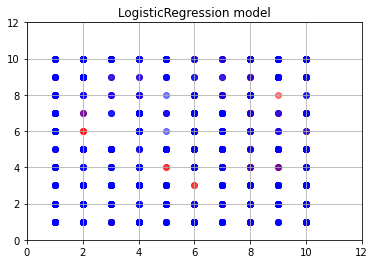

In [27]:
pylab.grid(True)
pylab.xlim(0, 12)
pylab.ylim(0, 12)
pylab.scatter(y_train, logit_grid_searcher1.predict(X_train), alpha=0.5,  color='red')
pylab.scatter(y_valid, logit_grid_searcher1.predict(X_valid), alpha=0.5, color='blue')
pylab.title('LogisticRegression model')

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [28]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', random_state=17) 
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 1min 50s, total: 3min 11s
Wall time: 1min 1s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     multi_class='multinomial', random_state=17)

In [29]:
logit_grid_searcher2.Cs_

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

In [30]:
logit_grid_searcher2.scores_[1].mean(axis=1)

array([0.76015744, 0.77844083, 0.75599593, 0.75894309, 0.77278963])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [31]:
plot_logit_validation_curves(logit_grid_searcher2.Cs_)

  0%|          | 0/20 [00:00<?, ?it/s]

{0.1: 0.736435699011059, 0.4631578947368421: 0.752895830390794, 2.642105263157895: 0.7565541501574723, 1.9157894736842107: 0.7566556522773397, 3.005263157894737: 0.7566557451996342, 2.278947368421053: 0.756757309267698, 0.8263157894736842: 0.7568585326206813, 1.1894736842105265: 0.7570618775754964, 5.184210526315789: 0.7574683816405369, 1.5526315789473686: 0.7574684745628316, 6.273684210526316: 0.7578747618091847, 5.5473684210526315: 0.7578749166796758, 3.368421052631579: 0.7578749786278722, 4.821052631578947: 0.7580779518935086, 5.910526315789474: 0.7580780138417049, 6.636842105263158: 0.7581795469356706, 4.457894736842105: 0.7582813897706182, 7.0: 0.7584844559585493, 4.094736842105263: 0.7586879557838553, 3.7315789473684213: 0.7595005612506598}


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'LogisticRegression model')

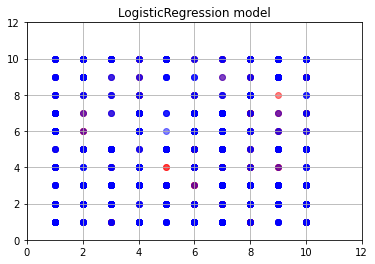

In [32]:
pylab.grid(True)
pylab.xlim(0, 12)
pylab.ylim(0, 12)
pylab.scatter(y_train, logit_grid_searcher2.predict(X_train), alpha=0.5,  color='red')
pylab.scatter(y_valid, logit_grid_searcher2.predict(X_valid), alpha=0.5, color='blue')
pylab.title('LogisticRegression model')

 Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [33]:
logit_best = LogisticRegression(C=3.7315789473684213, random_state=17)
logit_best.fit(X_train, y_train)
logit_cv_acc = accuracy_score(y_valid, logit_best.predict(X_valid))
print(logit_cv_acc)

0.7843090779805642


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [34]:
logit_grid_searcher2 = LogisticRegression(C=3.7315789473684213, random_state=17) 
res_logit_searcher2 = cross_val_score(logit_grid_searcher2, X_train, y_train, cv=skf, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

LogisticRegression(C=3.7315789473684213, random_state=17)

In [35]:
print(np.mean(res_logit_searcher2))
print(accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid)))

0.7595005612506598
0.7843090779805642


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [36]:
from sklearn.svm import LinearSVC

In [37]:
svm = LinearSVC(C=1, random_state=17)
res_svm = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
svm.fit(X_train, y_train)
print(np.mean(res_svm))
print(accuracy_score(y_valid, svm.predict(X_valid)))

0.7518800038655674
0.7757762502962787


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [38]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid = svm_params1, cv=skf, n_jobs=-1) 
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 1.59 s, sys: 15.3 ms, total: 1.6 s
Wall time: 6.06 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])})

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [39]:
print(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_)

0.6905092265643779 {'C': 5555.555600000001}


In [40]:
svm_grid_searcher1.param_grid

{'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
        4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
        8.8888889e+03, 1.0000000e+04])}

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [41]:
def plot_linSVM_validation_curves(reg_par_C):
    dict = {}
    for key, value in reg_par_C.items():
        for i in tqdm(value):
            svm = LinearSVC(C=i, random_state=17)
            svm.fit(X_train, y_train)
            dict[i] = np.mean(cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1))      
    svm_params1_C, svm_grid_searcher1_cv_results_ = zip(*dict.items())
    plt.plot(svm_params1_C, svm_grid_searcher1_cv_results_)
    plt.grid(True)
    plt.xlabel('logit c values')
    plt.ylabel('logit mean cv scores')
    plt.show()
    
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

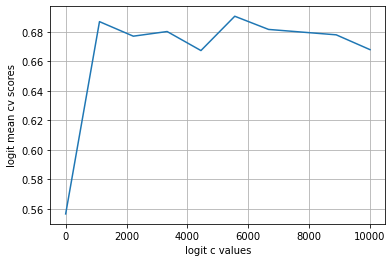

In [42]:
plot_linSVM_validation_curves(svm_grid_searcher1.param_grid)

Text(0.5, 1.0, 'Random Forest model')

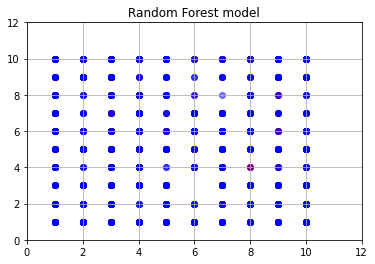

In [43]:
pylab.grid(True)
pylab.xlim(0, 12)
pylab.ylim(0, 12)
pylab.scatter(y_train, svm_grid_searcher1.predict(X_train), alpha=0.5,  color='red')
pylab.scatter(y_valid, svm_grid_searcher1.predict(X_valid), alpha=0.5, color='blue')
pylab.title('Random Forest model')

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [44]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid = svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 801 ms, sys: 126 ms, total: 927 ms
Wall time: 9.07 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])})

In [45]:
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_)

0.7608208631613899 {'C': 0.24213793103448275}


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

In [46]:
plot_linSVM_validation_curves(svm_grid_searcher2.param_grid)

  0%|          | 0/30 [00:00<?, ?it/s]

In [47]:
pylab.grid(True)
pylab.xlim(0, 12)
pylab.ylim(0, 12)
pylab.scatter(y_train, svm_grid_searcher2.predict(X_train), alpha=0.5,  color='red')
pylab.scatter(y_valid, svm_grid_searcher2.predict(X_valid), alpha=0.5, color='blue')
pylab.title('Random Forest model')

Text(0.5, 1.0, 'Random Forest model')

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [48]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train, y_train)
svm_cv_acc = accuracy_score(y_valid, svm.predict(X_valid))
print(svm_cv_acc)

0.7757762502962787


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [49]:
svm2_best = LinearSVC(C=0.24213793103448275, random_state=17)
res_svm2_best = cross_val_score(svm2_best, X_train, y_train, cv=skf, n_jobs=-1)
svm2_best.fit(X_train, y_train)

LinearSVC(C=0.24213793103448275, random_state=17)

In [50]:
print(np.mean(res_svm2_best))
print(accuracy_score(y_valid, svm2_best.predict(X_valid)))

0.7608208631613899
0.7814648020858023


In [51]:
n_trees = range(1, 56, 5)

In [52]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = RandomForestClassifier(n_estimators = n_tree, min_samples_split=5)
    score = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=3)
    scoring.append(score)
scoring=np.asmatrix(scoring)

CPU times: user 32.7 s, sys: 49.7 ms, total: 32.7 s
Wall time: 32.7 s


In [53]:
scoring

matrix([[0.57208168, 0.59463578, 0.60030488],
        [0.68790003, 0.67662298, 0.67987805],
        [0.70192015, 0.69399573, 0.69969512],
        [0.7110637 , 0.70009144, 0.71036585],
        [0.71167327, 0.69948187, 0.71920732],
        [0.7171594 , 0.70953977, 0.71829268],
        [0.72295032, 0.70466321, 0.72317073],
        [0.72112161, 0.7028345 , 0.7152439 ],
        [0.72081682, 0.71289241, 0.71859756],
        [0.72203596, 0.71350198, 0.71493902],
        [0.72721731, 0.70923499, 0.72195122]])

In [54]:
y_train = LabelEncoder().fit_transform(y_train)

In [55]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate = 0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=3)
    xgb_scoring.append(score)
xgb_scoring=np.asmatrix(xgb_scoring)

CPU times: user 1min 59s, sys: 18.6 s, total: 2min 18s
Wall time: 23.2 s


In [56]:
xgb_scoring

matrix([[0.55653764, 0.53367876, 0.54481707],
        [0.58793051, 0.58640658, 0.58353659],
        [0.59158793, 0.60530326, 0.59359756],
        [0.60286498, 0.61414203, 0.59939024],
        [0.61292289, 0.62389515, 0.61097561],
        [0.62145687, 0.63181957, 0.6195122 ],
        [0.6290765 , 0.63395306, 0.62835366],
        [0.63486742, 0.63913441, 0.63445122],
        [0.63669613, 0.64401097, 0.63963415],
        [0.64004877, 0.64583968, 0.64603659],
        [0.6455349 , 0.64766839, 0.65060976]])

In [57]:
pylab.plot(n_trees, scoring.mean(axis=1), marker='.', label='RandomForest', color='red')
pylab.plot(n_trees, xgb_scoring.mean(axis=1), marker='.', label='XGBoost', color='blue')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Acuracy score')
pylab.legend('lower right')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [51]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    t_start = time()

    with open(path_to_X_pickle, 'rb') as f:
        X_sparse = pickle.load(f)
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f)

    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                          random_state=random_state,
                                                          stratify=y)

    scores = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    estimator.fit(X_train, y_train)
  
    acc_score = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return scores.mean(), acc_score, time() - t_start

**Убедитесь, что функция работает.**

In [52]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join('../capstone_user_identification/X_sparse_10users.pkl'),
        os.path.join('../capstone_user_identification/y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7608208631613899, 0.7814648020858023, 1.100017786026001)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [53]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [54]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm(itertools.product([10, 7, 5], [15, 10, 7, 5])):
    if window_size <= session_length and (window_size, session_length):
        path_to_X_pkl = '../second_week/X_sparse_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        path_to_y_pkl = '../second_week/y_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
        print("Session length: {}, Window size: {}".format(session_length, window_size))
        print(np.mean(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3)))

0it [00:00, ?it/s]

Session length: 15, Window size: 10
1.1474060484579
Session length: 10, Window size: 10
0.9131005979214506
Session length: 15, Window size: 7
1.363445235339638
Session length: 10, Window size: 7
1.0988161416614672
Session length: 7, Window size: 7
0.7995777635590443
Session length: 15, Window size: 5
1.611603878027438
Session length: 10, Window size: 5
1.260499469401213
Session length: 7, Window size: 5
0.9641448571920787
Session length: 5, Window size: 5
0.7286889642473012
CPU times: user 8.19 s, sys: 91.3 ms, total: 8.28 s
Wall time: 15.2 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [55]:
cv_score, accur_score, _ = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join('../second_week/X_sparse_10users_s15_w5.pkl'),
        os.path.join('../second_week/y_10users_s15_w5.pkl'), skf, random_state=17, test_size=0.3)

In [56]:
print(cv_score, accur_score)

0.8692714587182452 0.8816974869606449


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [57]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm([(5,5), (7,7), (10,10)]):
    path_to_X_pkl = '../second_week/X_sparse_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
    path_to_y_pkl = '../second_week/y_10users_s' + \
                        str(session_length) + '_w' + str(window_size) + '.pkl'
    print("Session length: {}, Window size: {}".format(session_length, window_size))
    print(np.mean(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=7, test_size=0.3)))

  0%|          | 0/3 [00:00<?, ?it/s]

Session length: 5, Window size: 5
0.7264276434973826
Session length: 7, Window size: 7
0.7884680935557892
Session length: 10, Window size: 10
0.9045539276435371
CPU times: user 1.55 s, sys: 11.6 ms, total: 1.56 s
Wall time: 2.74 s


чем больше окно, тем точнее

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [58]:
cv_score, accur_score, _ = model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join('../capstone_user_identification/X_sparse_150users.pkl'),
        os.path.join('../capstone_user_identification/y_150users.pkl'), skf, random_state=17, test_size=0.3)

In [59]:
print(cv_score, accur_score)

0.46160583028369456 0.4811219773269109


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [60]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [61]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [62]:
C_opt=3.7315789473684213

In [63]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[C_opt], random_state=17, n_jobs=-1, multi_class='ovr')
logit_cv_150users.fit(X_train_150, y_train_150)

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/A117675686/PycharmProjects/internet_user_identification/courseraenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

KeyboardInterrupt: 

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [64]:
cv_scores_by_user = logit_cv_150users.scores_
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id].mean()))

AttributeError: 'LogisticRegressionCV' object has no attribute 'scores_'

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [ ]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    val = (class_distr.sum() - class_distr[user_id])/class_distr.sum()
    print(val)
    acc_diff_vs_constant[user_id] = (cv_scores_by_user[user_id].mean() - val)
    print("User: {} difference: {}".format(user_id, cv_scores_by_user[user_id].mean() -\
                                           val))    

In [ ]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [ ]:
num_better_than_default/len(np.unique(y_train_150))

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = y_150users == 128
y_binary_128.astype('int')

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, cv=skf, n_jobs=-1, train_sizes=train_sizes)

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.